In [1]:
import os

In [2]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In [3]:
import jax 
import jax.numpy as jnp
import optax
import numpy as np 
import matplotlib.pyplot as plt
import time 
import pickle
from tqdm import trange

In [4]:
from cmspinn.spinn_jax import SPINN3d, generate_train_data, apply_model_spinn, update_model

In [5]:
from pathlib import Path

In [6]:
b_bottom_path = '/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/data/inputs_12673.npy'
Nz = 50
b_norm = 2500

In [7]:
output_path = os.path.join('output')
os.makedirs(output_path, exist_ok=True)

In [8]:
b = np.load(b_bottom_path)*b_norm
b_bottom = b.squeeze().transpose(1, 2, 0)
b_bottom.shape

(513, 257, 3)

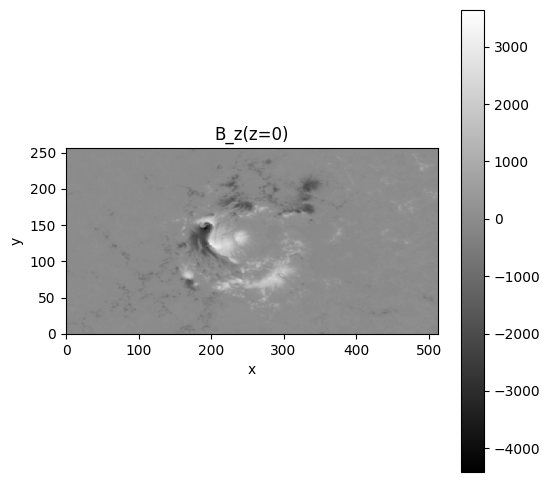

In [9]:
plt.close()
fig, ax = plt.subplots(figsize=(6,6))
CS = plt.imshow(b_bottom[:, :, 2].transpose(), origin='lower', cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("B_z(z=0)")
fig.colorbar(CS)
plt.show()

In [10]:
Nx, Ny, _ = b_bottom.shape

In [11]:
boundary_path = os.path.join(output_path, 'boundary.pickle')

In [12]:
with open(boundary_path, 'rb') as f:
    boundary_data = pickle.load(f)

In [13]:
epochs = 10000
log_iter = 1000

features = 256
n_layers = 8 
feat_sizes = tuple([features for _ in range(n_layers)]) 
r = 128 
out_dim = 3 

lr = 5e-4

In [14]:
pos_enc = 0
mlp = 'modified_mlp'

In [15]:
n_max_x = 2*(Nx/Nx)
n_max_y = 2*(Ny/Nx)
n_max_z = 2*(Nz/Nx)

parameters = {'feat_sizes' : feat_sizes, 
        'r' : r, 
        'out_dim' : out_dim, 
        'Nx' : Nx, 
        'Ny' : Ny, 
        'Nz' : Nz, 
        'b_norm' : b_norm,
        'pos_enc' : pos_enc,
        'mlp' : mlp,
        'lr': lr,
        'n_max_x': n_max_x,
        'n_max_y': n_max_y,
        'n_max_z': n_max_z,}

In [16]:
parameters_path = os.path.join(output_path, "parameters.pickle")
with open(parameters_path, "wb") as f:
    pickle.dump(parameters, f)

In [17]:
seed = 111
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key, 2)

2023-10-23 11:02:39.106389: W external/xla/xla/service/gpu/nvptx_compiler.cc:673] The NVIDIA driver's CUDA version is 11.4 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [18]:
model = SPINN3d(feat_sizes, r, out_dim, pos_enc=pos_enc, mlp=mlp)
params = model.init(
            subkey,
            jnp.ones((Nx, 1)),
            jnp.ones((Ny, 1)),
            jnp.ones((Nz, 1))
        )
apply_fn = jax.jit(model.apply)
optim = optax.adam(learning_rate=lr)
state = optim.init(params)

In [19]:
key, subkey = jax.random.split(key, 2)
train_data = generate_train_data(subkey, Nx, Ny, Nz, n_max_x, n_max_y, n_max_z)
train_boundary_data = [train_data, boundary_data]

In [20]:
losses = []

In [21]:
loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
losses.append(loss.item())
params, state = update_model(optim, gradient, params, state)

In [22]:
params_path = os.path.join(output_path, "params_0.pickle")
with open(params_path, "wb") as f:
    pickle.dump(params, f)

In [23]:
start = time.time()
for e in trange(1, epochs + 1):
    
    loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
    losses.append(loss.item())
    params, state = update_model(optim, gradient, params, state)
    
    if e % log_iter == 0:
        print(f'Epoch: {e}/{epochs} --> total loss: {loss:.8f}')
        params_path = os.path.join(output_path, f"params_{e}.pickle")
        with open(params_path, "wb") as f:
            pickle.dump(params, f)

np.save(os.path.join(output_path, 'losses.npy'), losses)
runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(epochs-1)*1000):.2f}ms/iter.)')

 10%|█         | 1002/10000 [00:58<09:22, 16.01it/s]

Epoch: 1000/10000 --> total loss: 0.03173660


 20%|██        | 2002/10000 [01:56<08:19, 16.02it/s]

Epoch: 2000/10000 --> total loss: 0.02473059


 30%|███       | 3002/10000 [02:53<06:59, 16.69it/s]

Epoch: 3000/10000 --> total loss: 0.02200555


 40%|████      | 4002/10000 [03:51<06:09, 16.23it/s]

Epoch: 4000/10000 --> total loss: 0.02086467


 50%|█████     | 5002/10000 [04:49<05:03, 16.48it/s]

Epoch: 5000/10000 --> total loss: 0.01998137


 60%|██████    | 6002/10000 [05:45<03:54, 17.06it/s]

Epoch: 6000/10000 --> total loss: 0.01874153


 70%|███████   | 7002/10000 [06:41<02:56, 17.03it/s]

Epoch: 7000/10000 --> total loss: 0.01811308


 80%|████████  | 8002/10000 [07:36<01:59, 16.78it/s]

Epoch: 8000/10000 --> total loss: 0.01724066


 90%|█████████ | 9002/10000 [08:32<00:58, 16.98it/s]

Epoch: 9000/10000 --> total loss: 0.01614982


100%|██████████| 10000/10000 [09:29<00:00, 17.57it/s]

Epoch: 10000/10000 --> total loss: 0.01534085
Runtime --> total: 569.08sec (56.91ms/iter.)


In [24]:
with open(os.path.join(output_path, 'losses.npy'), "rb") as f:
    losses = np.load(f)

Text(0, 0.5, 'Loss')

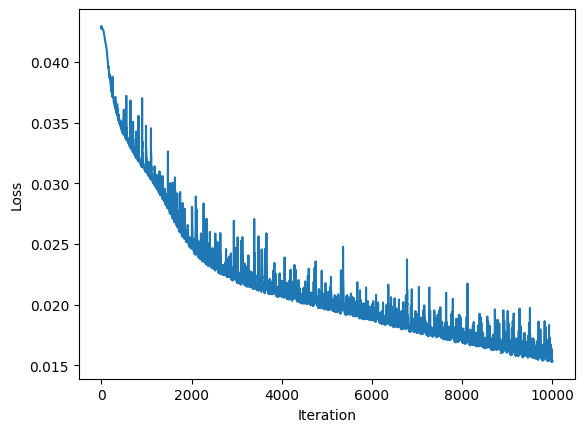

In [25]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')